# TC Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os.path as op
import xarray as xr
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../../../functions")
from tcs import Extract_Circle
from data_downloaders import download_ibtracs

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_tcs import Plot_TCs_HistoricalTracks_Category
from ind_setup.plotting import plot_bar_probs, plot_tc_categories_trend
from ind_setup.tables import plot_df_table


In [2]:
lon_lat = [134.5, 5.5] #Palau location lon, lat
basin = 'WP'
r1 = 5 # Radius of the circular area in degrees

## Get Data

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/netcdf/IBTrACS.ALL.v04r01.nc'
    tcs = download_ibtracs(url, basin = basin)
    tcs.to_netcdf(f"{path_data}/tcs_{basin}.nc")
else:
    tcs = xr.load_dataset(f"{path_data}/tcs_{basin}.nc")

In [5]:
tcs = tcs.isel(storm = np.where(tcs.isel(date_time = 0).time.dt.year >= 1950)[0])    

In [6]:
# tcs = xr.open_dataset('/Users/laurac/Downloads/IBTrACS.ALL.v04r01.nc')

In [7]:
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',
    'wind': 'wmo_wind',
}
tcs_sel, tcs_sel_params = Extract_Circle(tcs, lon_lat[0], lon_lat[1], r1, d_vns, fillwinds=True)

In [8]:
tcm = tcs_sel.max(dim = 'date_time')
tcmin = tcs_sel.min(dim = 'date_time')

## All TCs

In [9]:
tcs_sel_params['category'] = (('storm'), np.where(np.isnan(tcs_sel_params.category), -1, tcs_sel_params.category))

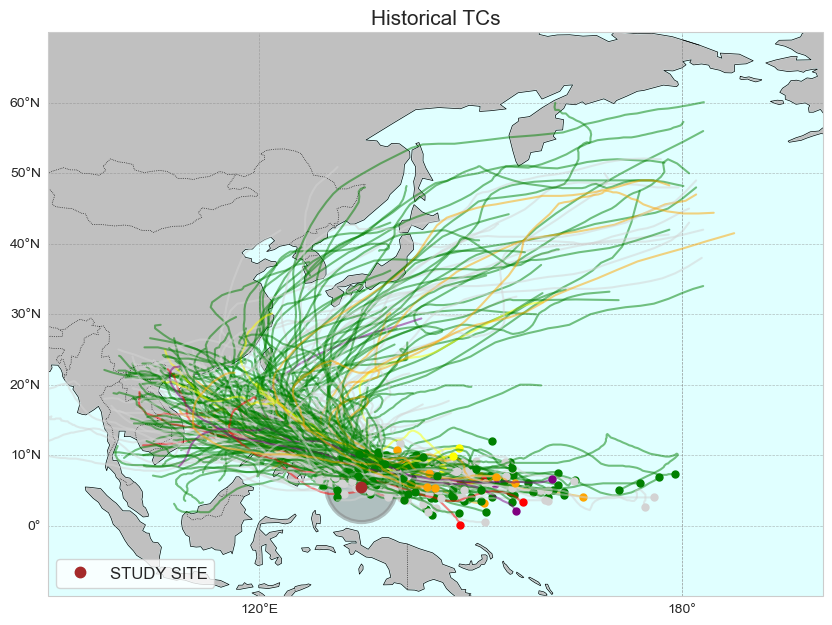

In [10]:
lon1, lon2 = 90, 200
lat1, lat2 = -10, 70

# r1
ax = Plot_TCs_HistoricalTracks_Category(
    tcs_sel, tcs_sel_params.category,
    lon1, lon2, lat1, lat2,
    lon_lat[0], lon_lat[1], r1,
)

plt.savefig(op.join(path_figs, 'F8_TCs_Historical.png'), dpi=300, bbox_inches='tight')


Text(0.5, 0, 'Month')

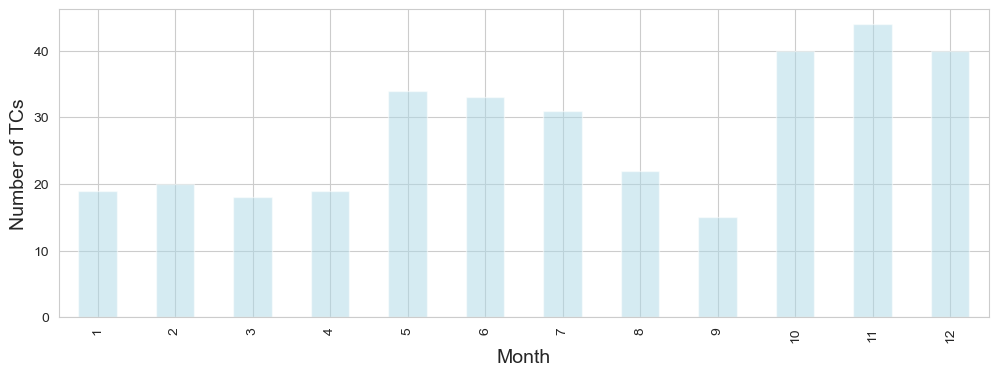

In [11]:
import matplotlib.pyplot as plt
tcs_sel_params['month'] =  tcs_sel_params.dmin_date.dt.month
tcs_sel_params.to_dataframe().groupby('month').count().index_in.plot.bar(figsize = (12, 4), color = 'lightblue', alpha = .5)
plt.ylabel('Number of TCs', fontsize = 14)
plt.xlabel('Month', fontsize = 14)

## Severe TCs

In [12]:
tcs_sel_params_severe = tcs_sel_params.where(tcs_sel_params.category >=3, drop=True)
tcs_sel_severe = tcs_sel.sel(storm=tcs_sel_params_severe.storm)

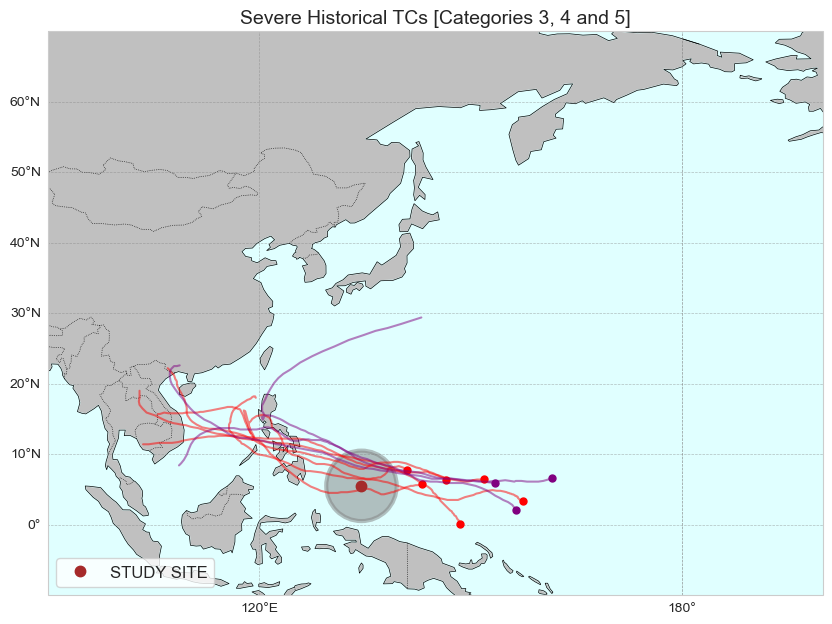

In [13]:

lon1, lon2 = 90, 200
lat1, lat2 = -10, 70

# r1
ax = Plot_TCs_HistoricalTracks_Category(
    tcs_sel_severe, tcs_sel_params_severe.category,
    lon1, lon2, lat1, lat2,
    lon_lat[0], lon_lat[1], r1,
)
ax.set_title('Severe Historical TCs [Categories 3, 4 and 5]', fontsize = 14)

plt.savefig(op.join(path_figs, 'F8_TCs_Historical_Severe.png'), dpi=300, bbox_inches='tight')


## Count TCs by category

In [14]:
u, c = np.unique(tcs_sel_params.category, return_counts=True)

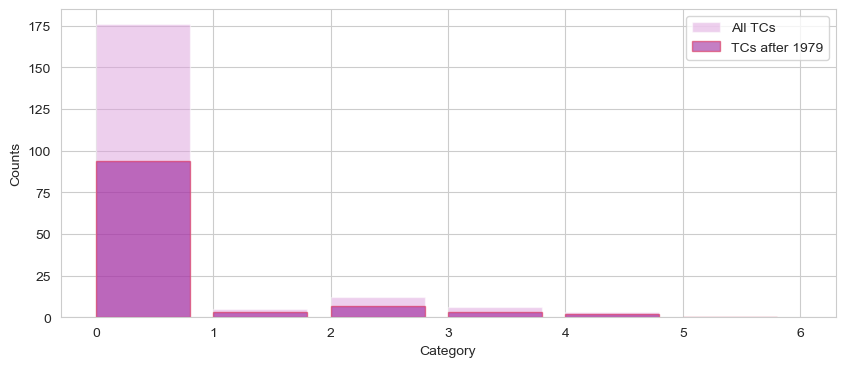

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10, 4))
ax.grid(zorder = -1)
tcs_sel_params.category.plot.hist(bins=range(7), ax=ax, color='plum', alpha=0.5, edgecolor= None, width = .8, linewidth=1, label = 'All TCs')
tcs_sel_params.where(tcs_sel_params.dmin_date.dt.year >=1979, 
                     drop = True).category.plot.hist(bins=range(7), ax=ax, 
                                                     color='darkmagenta', alpha=0.5, edgecolor='crimson', width = .8, linewidth=1, label = 'TCs after 1979')
ax.set_xlabel('Category')
ax.set_ylabel('Counts')

ax.legend()

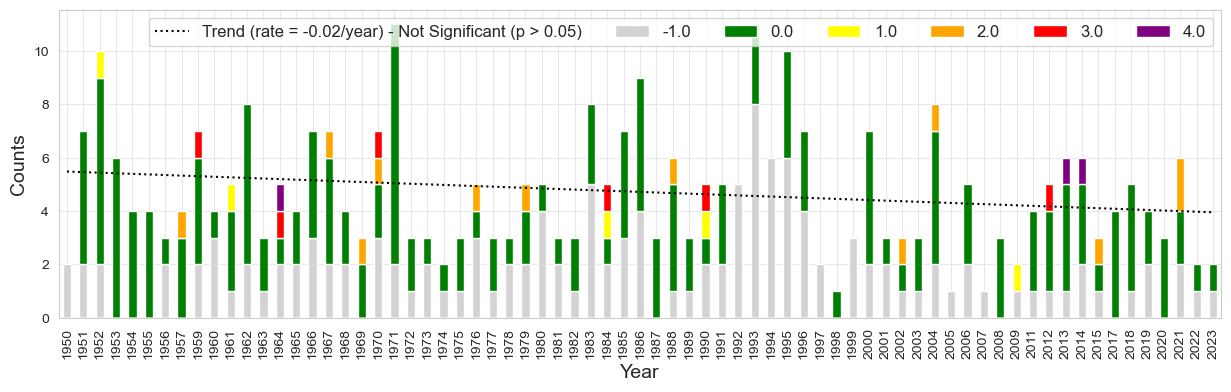

In [16]:
plot_tc_categories_trend(tcs_sel_params)
plt.savefig(op.join(path_figs, 'F8_TCs_Historical_bars_category.png'), dpi=300, bbox_inches='tight')

(<Figure size 1500x400 with 1 Axes>, <Axes: ylabel='Number TCs'>)

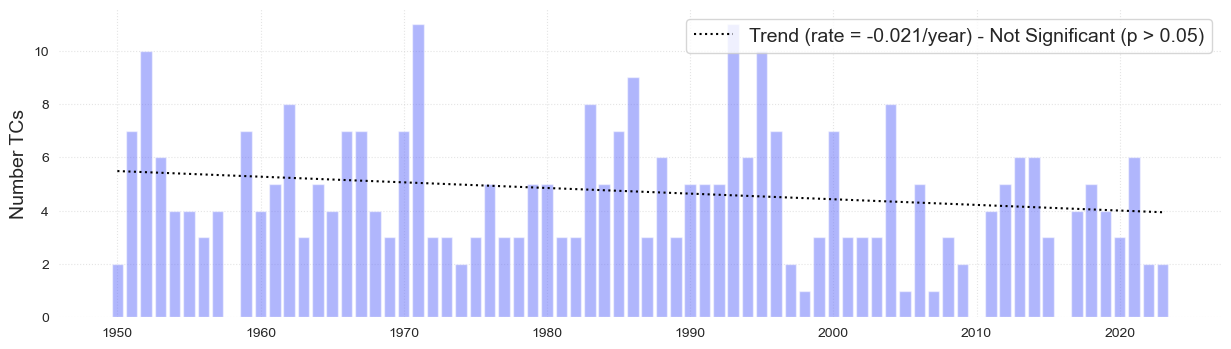

In [17]:
time = tcs_sel_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)
plot_bar_probs(x = u, y = cu, figsize= (15, 4), trendline = True,
               y_label =  'Number TCs')

(<Figure size 1500x400 with 1 Axes>, <Axes: ylabel='Number of severe TCs'>)

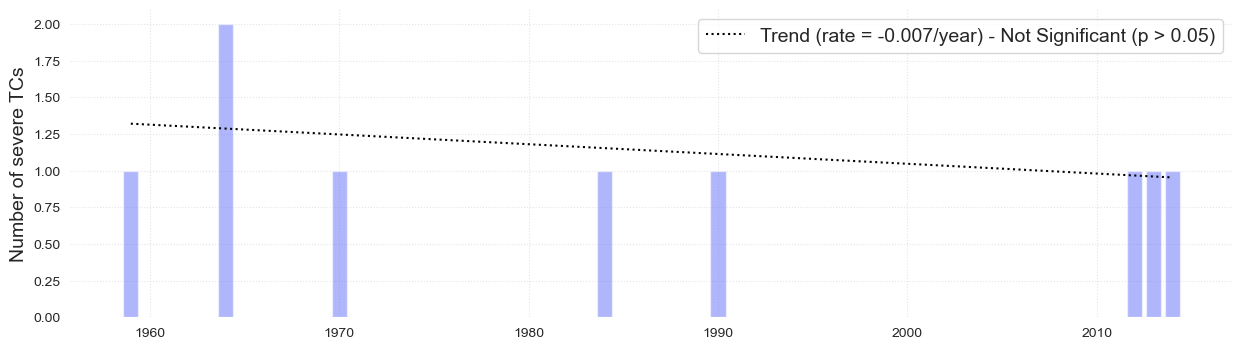

In [18]:
tcs_sel_severe_params = tcs_sel_params.where(tcs_sel_params.category >=3, drop = True)
time = tcs_sel_severe_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)
plot_bar_probs(x = u, y = cu, figsize= (15, 4), trendline = True,
               y_label =  'Number of severe TCs')

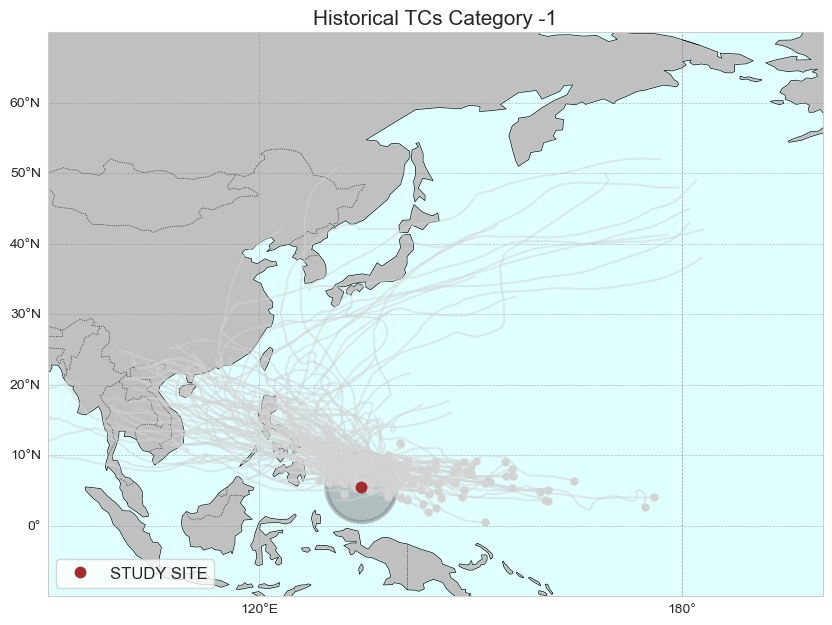

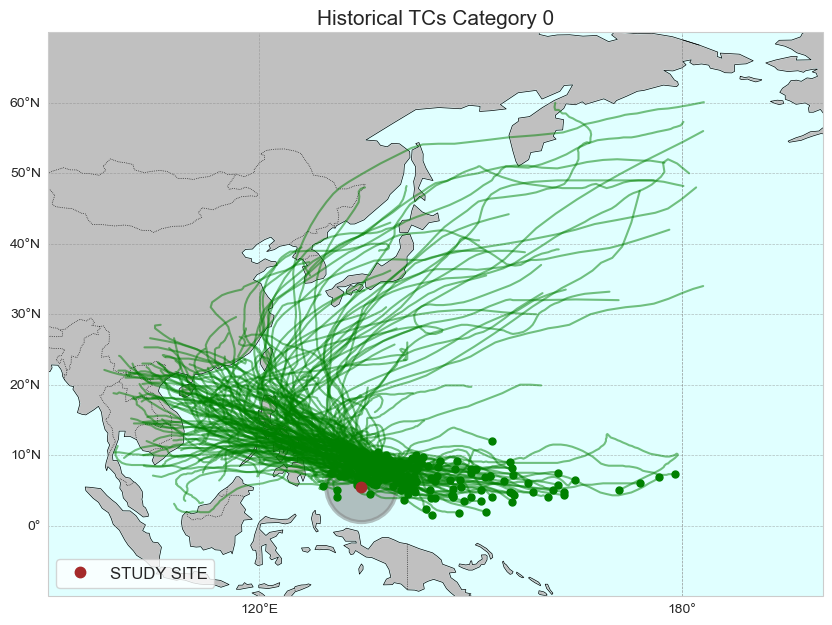

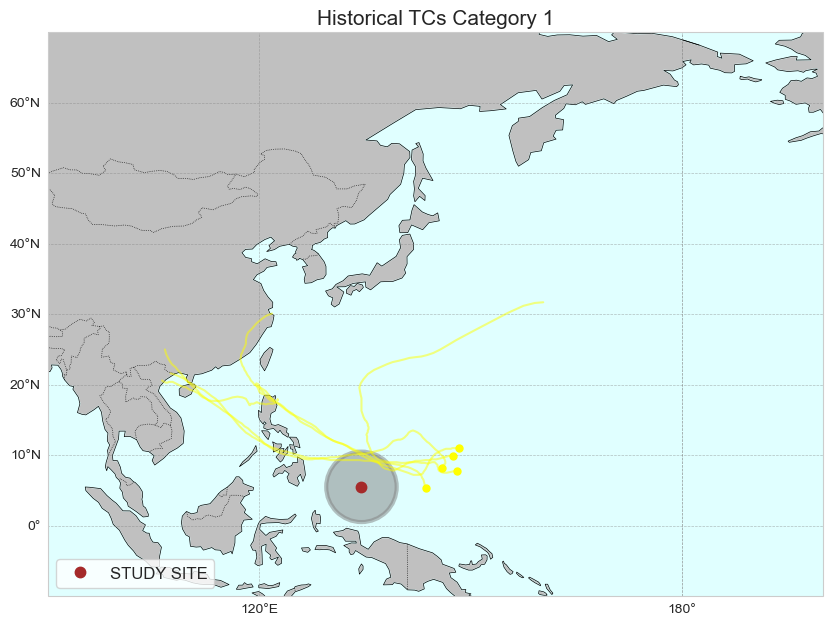

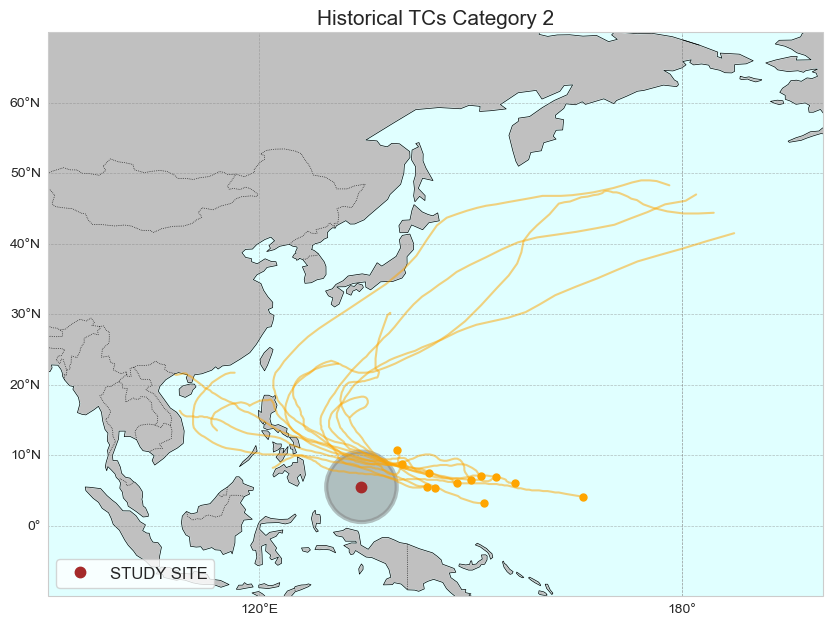

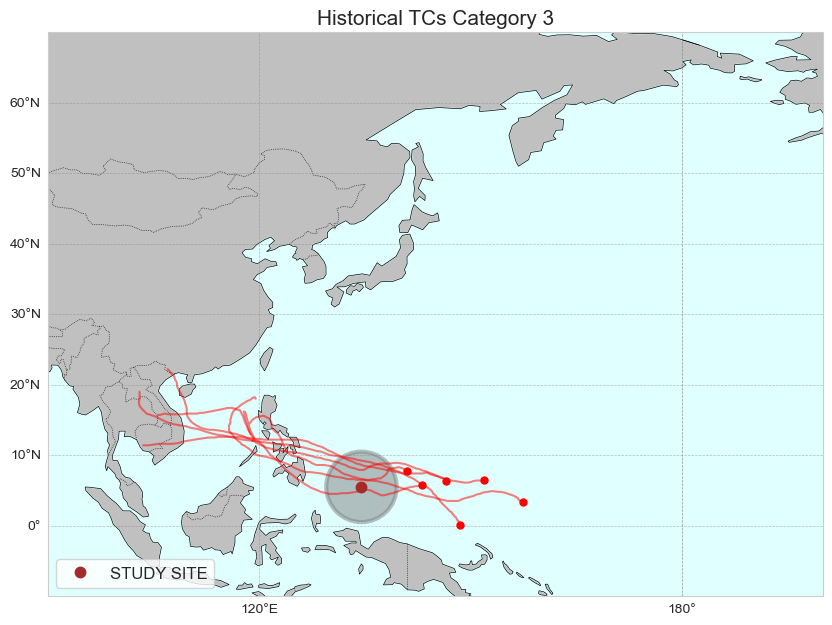

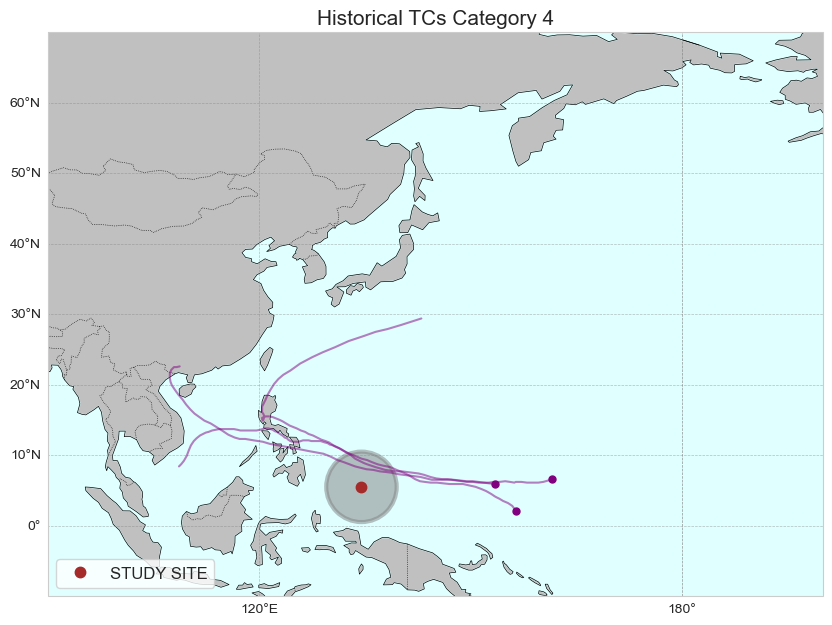

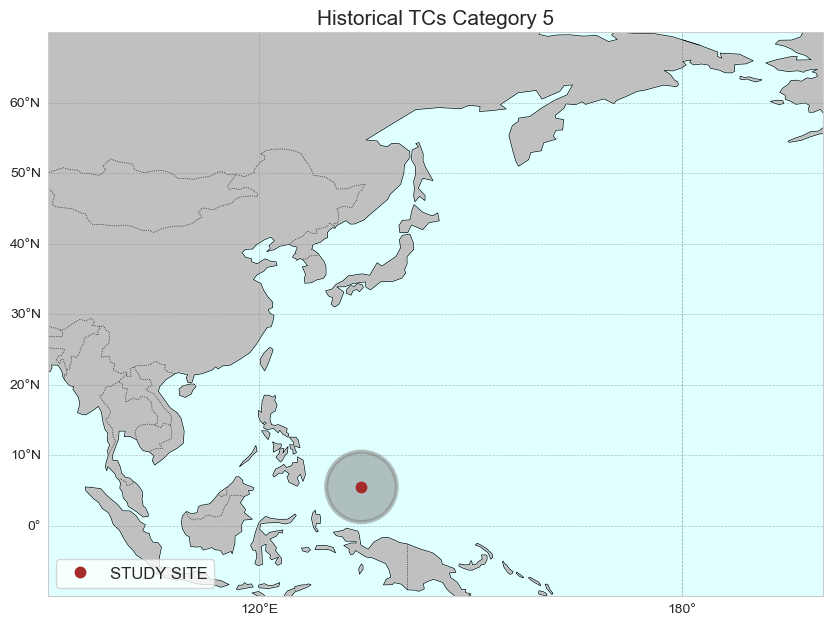

In [19]:

for category in np.arange(-1, 6, 1):

    tcs_cat = tcs_sel.where(tcs_sel_params.category == category, drop = True)
    tcs_cat_params = tcs_sel_params.where(tcs_sel_params.category == category, drop = True)

    # r1
    ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical TCs Category {category}', fontsize=15)

Number of TCs for each category

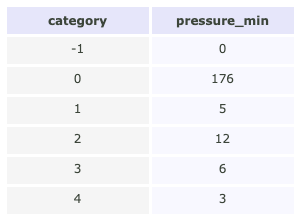

Mean TCs per year:  2.8450704225352115
Mean number of severe TCs per year:  1.12


In [20]:
df_tcs = tcs_sel_params.to_dataframe()
df_tcs['year'] = df_tcs.dmin_date.dt.year
df_t = df_tcs.groupby('category').count()[['pressure_min']]
fig = plot_df_table(df_t, figsize = (300, 220))

mean_tcs_per_year = df_tcs.groupby(df_tcs['dmin_date'].dt.year)['pressure_min'].count()

df_sev = df_tcs.loc[df_tcs['category'] >=3]
mean_tcs_per_year_sev = df_sev.groupby(df_sev['dmin_date'].dt.year)['pressure_min'].count()

print('Mean TCs per year: ', np.nanmean(mean_tcs_per_year))
print('Mean number of severe TCs per year: ', np.round(np.nanmean(mean_tcs_per_year_sev), 2))
